# <font color = 'blue' > Monkeypox Classification
## <font color= 'blue'> Creating a custom object classification model with YOLO

#<font color = "blue"> Imports

In [1]:
from IPython import display

In [2]:
!pip install matplotlib
!pip install roboflow
!pip install ultralytics
!pip install roboflow
!pip install tensorflow
!pip install torch
display.clear_output()

#<font color = "blue"> GPU Check

In [3]:
!nvidia-smi # making sure GPU is running

Sun Oct 27 15:14:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# another check to make sure GPU is working
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))
print('Num GPUs Available: ', numGPUs)
if numGPUs > 0:
  print(tf.test.gpu_device_name())
  print(device_lib.list_local_devices()[1].physical_device_desc)

# check if cuda is available
import torch
if torch.cuda.is_available():
  print("CUDA is available!")
else:
  print("CUDA is not available. Using CPU.")

Num GPUs Available:  1
/device:GPU:0
device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
CUDA is available!


# <font color = 'blue'> Load Monkeypox Dataset
- manually add kaggle.json file (contains api key) to kaggle folder --> not necessary
- use kagglehub to download dataset

In [ ]:
# # MANUALLY ADD KAGGLE.JSON FILE TO KAGGLE FOLDER
# import os
# import kagglehub


# kaggle_folder = "/content/kaggle"
# os.makedirs(kaggle_folder)

# # change current working directory to kaggle folder (kagglehub only downloads in current w directory)
# os.chdir(kaggle_folder)

In [ ]:
import os
# download latest version
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

print("Current working directory:", os.getcwd())  # kaggle folder path
print("Downloaded files:", os.listdir())  # downloaded data files

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 567M/567M [00:20<00:00, 33.3MB/s]
100% 567M/567M [00:20<00:00, 28.7MB/s]
Current working directory: /content/kaggle
Downloaded files: ['kaggle.json', 'mpox-skin-lesion-dataset-version-20-msld-v20.zip']


In [7]:
# unzip dataset file
#dataset_directory = "/content/kaggle/monkeypoxSet"
!unzip mpox-skin-lesion-dataset-version-20-msld-v20.zip -d monkeypoxSet
display.clear_output()

# <font color = 'blue'> Configure Dataset Structure
- must match ultralytics dataset structure requirements

In [11]:
import shutil
dataset_directory = "/content/kaggle/monkeypoxSet"
# change current working directory to download folder

os.chdir(dataset_directory)
print("Current working directory:", os.getcwd())


# Class directories to create
classes = ['Healthy', 'Monkeypox', 'Other']
source_dir = '/content/kaggle/monkeypoxSet/Original Images/Original Images/FOLDS'  # Replace with the actual path in your Colab environment
dest_train = '/content/kaggle/monkeypoxSet/train'
dest_val = '/content/kaggle/monkeypoxSet/val'

# Create the destination folders if they don't exist
for dest in [dest_train, dest_val]:
    for class_name in classes:
        os.makedirs(os.path.join(dest, class_name), exist_ok=True)

def move_images(source_folder, dest_folder, disease_class):
    for class_folder in os.listdir(source_folder):
        src_path = os.path.join(source_folder, class_folder)
        if os.path.isdir(src_path):
            # Determine the destination class
            if class_folder == 'Healthy':
                target_class = 'Healthy'
            elif class_folder == 'Monkeypox':
                target_class = 'Monkeypox'
            else:
                target_class = 'Other'

            # Move each image to the appropriate destination
            for img_file in os.listdir(src_path):
                img_src = os.path.join(src_path, img_file)
                img_dest = os.path.join(dest_folder, target_class, img_file)
                shutil.copy(img_src, img_dest)

# Move images from each fold's train, test, and valid folders
for fold in os.listdir(source_dir):
    fold_path = os.path.join(source_dir, fold)

    # Move training images to total_train
    train_path = os.path.join(fold_path, 'Train')
    if os.path.exists(train_path):
        move_images(train_path, dest_train, classes)

    # Move testing and validation images to total_val
    for val_type in ['Test', 'Valid']:
        val_path = os.path.join(fold_path, val_type)
        if os.path.exists(val_path):
            move_images(val_path, dest_val, classes)

print("Images have been successfully organized into train and val.")

Current working directory: /content/kaggle/monkeypoxSet
Images have been successfully organized into train and val.


In [15]:
# delete augmented images folder (remove this step later when augmented images are joined to training folders)
import shutil

# assuming working directory is still dataset_directory...
#os.chdir(dataset_directory)
print("Current working directory:", os.getcwd())
# check --> CURRENT DIRECTORY DOES NOT MATTER, have to provide full path

folder1_delete = "/content/kaggle/monkeypoxSet/Augmented Images"
folder2_delete = "/content/kaggle/monkeypoxSet/Original Images"

folder_classes = [folder1_delete, folder2_delete]

for folder_path in folder_classes:
# Check if the folder exists
  if os.path.exists(folder_path):
      # Delete the folder and its contents
      shutil.rmtree(folder_path)
      print(f"Folder '{folder_path}' and its contents have been deleted.")
  else:
      print(f"Folder '{folder_path}' does not exist.")

Current working directory: /content/kaggle/monkeypoxSet
Folder '/content/kaggle/monkeypoxSet/Augmented Images' and its contents have been deleted.
Folder '/content/kaggle/monkeypoxSet/Original Images' and its contents have been deleted.


In [12]:
#counting number of images
def count_images(folder_path):
    # Set of common image file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

    # Count files with these extensions
    image_count = sum(1 for file in os.listdir(folder_path)
                      if os.path.isfile(os.path.join(folder_path, file))
                      and os.path.splitext(file)[1].lower() in image_extensions)
    return image_count

train_folder_ls = ['/content/kaggle/monkeypoxSet/train/Healthy', '/content/kaggle/monkeypoxSet/train/Monkeypox', '/content/kaggle/monkeypoxSet/train/Other']
val_folder_ls = ['/content/kaggle/monkeypoxSet/val/Healthy', '/content/kaggle/monkeypoxSet/val/Monkeypox', '/content/kaggle/monkeypoxSet/val/Other']
folder_path = '/content/total_train/Healthy'  # Replace with your folder path

print("Training Dataset:")
for folder_path in train_folder_ls:
  image_count = count_images(folder_path)
  print(f"Number of images in '{folder_path}': {image_count}")

print("")
print("Validation Dataset:")
for folder_path in val_folder_ls:
  image_count = count_images(folder_path)
  print(f"Number of images in '{folder_path}': {image_count}")

Training Dataset:
Number of images in '/content/kaggle/monkeypoxSet/train/Healthy': 114
Number of images in '/content/kaggle/monkeypoxSet/train/Monkeypox': 284
Number of images in '/content/kaggle/monkeypoxSet/train/Other': 357

Validation Dataset:
Number of images in '/content/kaggle/monkeypoxSet/val/Healthy': 96
Number of images in '/content/kaggle/monkeypoxSet/val/Monkeypox': 242
Number of images in '/content/kaggle/monkeypoxSet/val/Other': 318


In [17]:
train_directory_path = "/content/kaggle/monkeypoxSet/train"
test_directory_path = "/content/kaggle/monkeypoxSet/val"
# print class names for .yaml file:
i = 0

for filename in os.listdir(train_directory_path):

  if os.path.isdir(os.path.join(train_directory_path, filename)):  # check if directory exists
    print(str(i) + ": ", filename)
    i += 1

0:  Healthy
1:  Other
2:  Monkeypox


In [18]:
# before starting to train model, need to change directory again (back to content folder)
# .yaml file is assuming current directory is in content folder --> in .yaml file, referenced val images as test directory
# (YAML FILE NOT REQUIRED)

# change current working directory to content folder
content_folder = "/content"
os.chdir(content_folder)
print("Current working directory:", os.getcwd())

Current working directory: /content


# <font color = "blue"> Set up Model

In [19]:
from roboflow import Roboflow
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
dataset_config_path = '/content/kaggle/monkeypoxSet' # DO NOT HAVE TO USE A .YAML FILE

# <font color = "blue"> Benchmark YOLO
- 25 images per batch

#### *metrics*
**Average Precision (AP)**
- computes the area under the precision-recall curve
- providing a single value that encapsulates model's precision and recall performance

**Mean Average Precision (mAP)**
- mAP extends the concept of AP by calculating the average AP values across multiple object classes
- useful in multi-class object detection scenarios
- provides comprehensive evaluation of model performance

**Precision and Recall**
- precision quantifies proportion of true positives among all positive predictions, assessing the model's capability to avoid false positives. On the other hand, Recall calculates the proportion of true positives among all actual positives, measuring the model's ability to detect all instances of a class.

**F1 Score**
- harmonic mean of precision and recall
- balanced assessment of a model's performance while considering both false positives and false negatives

In [23]:
model.names # run after setting up model

{0: 'Healthy', 1: 'Monkeypox', 2: 'Other'}

#### <font color = 'purple'> train model

In [22]:
from ultralytics import YOLO

dataset_config_path = '/content/kaggle/monkeypoxSet' # DO NOT HAVE TO USE A .YAML FILE
model = YOLO('yolov8n-cls.pt') # load a pretrained model
model.train(data=dataset_config_path, epochs=10, batch=25) # default images per batch is 16

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/kaggle/monkeypoxSet, epochs=10, time=None, patience=100, batch=25, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 5.35M/5.35M [00:00<00:00, 145MB/s]


AMP: checks passed ✅


train: Scanning /content/kaggle/monkeypoxSet/train... 755 images, 0 corrupt: 100%|██████████| 755/755 [00:00<00:00, 3859.77it/s]

train: New cache created: /content/kaggle/monkeypoxSet/train.cache



val: Scanning /content/kaggle/monkeypoxSet/val... 656 images, 0 corrupt: 100%|██████████| 656/656 [00:00<00:00, 1803.41it/s]

val: New cache created: /content/kaggle/monkeypoxSet/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005859375000000001), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10     0.382G      1.206         25        224:  19%|█▉        | 6/31 [00:01<00:05,  4.53it/s]

       1/10     0.382G      1.187         25        224:  32%|███▏      | 10/31 [00:02<00:03,  5.56it/s]
100%|██████████| 755k/755k [00:00<00:00, 30.5MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all      0.598          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s]

                   all      0.759          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s]

                   all      0.858          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:01<00:00,  8.18it/s]

                   all      0.901          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:01<00:00,  8.52it/s]

                   all      0.921          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.344G     0.2994          5        224: 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]

                   all      0.945          1



10 epochs completed in 0.024 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/kaggle/monkeypoxSet/train... found 755 images in 3 classes ✅ 
val: /content/kaggle/monkeypoxSet/val... found 656 images in 3 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:01<00:00,  8.04it/s]


                   all      0.945          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a7d63febe80>
curves: []
curves_results: []
fitness: 0.9725609719753265
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9451219439506531, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9725609719753265}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.08891522884368896, 'inference': 0.45723159138749286, 'loss': 0.00038234198965677403, 'postprocess': 0.00030202109639237566}
task: 'classify'
top1: 0.9451219439506531
top5: 1.0

#### <font color = 'purple'> download training results

In [ ]:
# download training results

In [26]:
# THIS CODE MAY NOT BE REPRODUCIBLE --> have to look at runs folder to see if there are multiple trains or not
# delete train folder. only need train2 folder for run. and rename train2 to train

folder_path = '/content/runs/classify/train'
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' and its contents have been deleted.")
else:
    print(f"Folder '{folder_path}' does not exist.")

current_dir = '/content/runs/classify/train2'
new_dir = '/content/runs/classify/train'
os.rename(current_dir, new_dir)
print("Directory renamed successfully.")

Folder '/content/runs/classify/train' and its contents have been deleted.
Directory renamed successfully.


In [27]:
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/classify/ (stored 0%)
  adding: content/runs/classify/train/ (stored 0%)
  adding: content/runs/classify/train/results.png (deflated 9%)
  adding: content/runs/classify/train/results.csv (deflated 61%)
  adding: content/runs/classify/train/events.out.tfevents.1730047015.d2a543c2b099.1149.0 (deflated 93%)
  adding: content/runs/classify/train/confusion_matrix_normalized.png (deflated 30%)
  adding: content/runs/classify/train/val_batch2_labels.jpg (deflated 1%)
  adding: content/runs/classify/train/val_batch0_pred.jpg (deflated 3%)
  adding: content/runs/classify/train/val_batch2_pred.jpg (deflated 1%)
  adding: content/runs/classify/train/val_batch1_labels.jpg (deflated 2%)
  adding: content/runs/classify/train/train_batch2.jpg (deflated 4%)
  adding: content/runs/classify/train/val_batch1_pred.jpg (deflated 1%)
  adding: content/runs/classify/train/train_batch1.jpg (deflated 3%)
  adding: content/runs/classify/train/val_batch0

In [28]:
from google.colab import files
files.download('runs.zip')
#files.download('yolo11n.pt')
#files.download('yolov8n-cls.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### <font color = 'purple'> run validation results


In [29]:
validation_results = model.val()

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,438,723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/kaggle/monkeypoxSet/train... found 755 images in 3 classes ✅ 
val: /content/kaggle/monkeypoxSet/val... found 656 images in 3 classes ✅ 
test: None...


val: Scanning /content/kaggle/monkeypoxSet/val... 656 images, 0 corrupt: 100%|██████████| 656/656 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 27/27 [00:02<00:00, 12.80it/s]


                   all      0.945          1
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


# <font color = 'blue'> Predict


0: 224x224 Monkeypox 0.68, Other 0.32, Healthy 0.00, 5.5ms
Speed: 6.6ms preprocess, 5.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
PICTURE CLASS =  1


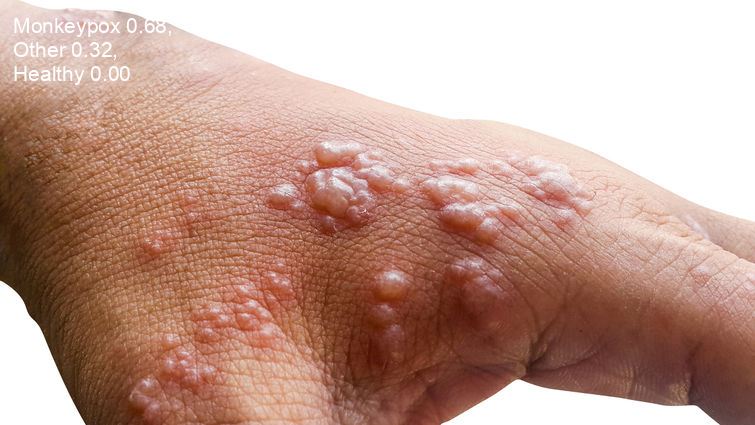

In [32]:

# Run batched inference on a list of images
results = model(["Monkeypox_1.jpg"])  # return a list of Results objects
print("PICTURE CLASS = ", results[0].probs.top1)
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk
# WILL ONLY PRINT ONE RESULT IMAGE BECAUSE THERE IS ONLY ONE IMAGE IN THE LIST